In [1]:
import sys
sys.path.append(r'/gs/fs/tga-isomura/Hiroto/old_tf/RNN_models/Test_brown_training/code_share/RNN_scripts')
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from decode_analyze import PerturbDecodeAnalyze
import os
import tensorflow as tf
from parula_colormap import parula
from get_folders import load_checkpoint_with_max_number, load_npy_with_max_number

In [2]:
# set hyperparamaters
weight_ind=0
seed=30#seed_num[weight_ind]
seed1=int(seed)
np.random.seed(seed1)
tf.random.set_seed(seed1)
random.seed(seed1)
nUnit=512
batch_sz=32
min_dur=6000 # minimum duration
max_dur=12000 # maximum duration
# make input function
inputdur=int(30) # duration of input in ms
nInh=int(np.ceil(nUnit/5)) # number of inhibitory units (from dales law)
nInput=1# number of input units
sample_size=8
tau=100
dt=10 #discretization time stamp
trial_num=3
con_prob=0 # probability of connection between neurons
maxval=0
ReLUalpha=0.2
batch_size=32

# scale time parameters by dt
min_dur=int(min_dur/dt) # minimum duration
max_dur=int(max_dur/dt) # maximum duration
# make input function
inputdur=int(inputdur/dt) # duration of input in ms
tau=tau/dt



# Parameters for the analysis (make sure these are defined in your code)
sample_size = 12
trial_num = 8
pert_state = 0       # 0: perturb RNN A, 1: perturb RNN B
pert_noisesd = 1.0   # perturb noise standard deviation
stop = False
option = 0           # 0: use circular mean; 1: use arithmetic mean
trial1 = 2

pert_prob = 1/100
pert_A_prob = 0.5
order = 1  

exp=0.5 #pink noise 
brown_scale=3 # noise gain
nohigh=True # remove high frequency noise


# Choose the dimensionality reduction method ("pca", "cca", or "pls")
dim_method = "cca"  # or "cca" or "pls"
pre_method="pca"
Dim=100
lin_method="act_stack"
max_drop_num=1
dropout_num=np.concatenate(([None],np.arange(max_drop_num)))
# Instantiate the analysis class.
analysis = PerturbDecodeAnalyze(min_dur, max_dur, dt, dim_method, Dim=Dim, lin_method=lin_method, nohigh=nohigh)

In [3]:
# load the model
model_path=r"/gs/fs/tga-isomura/Hiroto/old_tf/RNN_models/Test_brown_training/code_share/RNN_models"

noise_weights=np.load(os.path.join(model_path,"noise_weights.npy"))
rank=np.shape(noise_weights)[0]

# Build the base model (assume build_model is defined elsewhere)
model = analysis.build_model_brown(nUnit=nUnit, nInh=nInh, nInput=nInput,
                    con_prob=con_prob, maxval=maxval, ReLUalpha=ReLUalpha, seed1=seed1, tau=tau,
                    rank=rank, exp=exp, noise_weights=noise_weights)

In [5]:
# run the model
# decode and analyze
# analyze single case
# Parameters for the analysis (make sure these are defined in your code)
sample_size = 4 #16
trial_num = 8 # 24
pert_state = 0       # 0: perturb RNN A, 1: perturb RNN B
pert_noisesd = 0.8 #0.8 3,5  # perturb noise standard deviation
stop = False
option = 1          # 0: use circular mean; 1: use arithmetic mean
trial1 = 2

pert_prob = 0.005
pert_A_prob = 0.5
order = 1  # order=1 means start with min_dur



ckeckpoint_filepath2,_ = load_checkpoint_with_max_number(model_path)
model.load_weights(ckeckpoint_filepath2)


# Create an "activity model" to output intermediate layer activations
activity_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[1:]])

# Generate input, output, and onset times using the analysis class method.
#-> it may be better to set brown_scale to 0
x, y, In_ons = analysis.makeInOut_sameint_brown(sample_size, trial_num, inputdur, nInput, order,brown_scale=brown_scale, rank=rank, exp=exp)

input_noise=np.matmul(x[:,:,1:],noise_weights)# batch, time, unit

output_and_activities = activity_model.predict(x)
activities_A = output_and_activities[1]
activities_B = output_and_activities[2]

# Compute averaged and stacked activations.
act_avg_A = analysis.avgAct2(activities_A, In_ons)
act_avg_B = analysis.avgAct2(activities_B, In_ons)
act_avg_A_orig=act_avg_A.copy()
act_avg_B_orig=act_avg_B.copy()

act_stack_A = analysis.concatAct(activities_A, In_ons)
act_stack_B = analysis.concatAct(activities_B, In_ons)
act_stack_A_orig=act_stack_A
act_stack_B_orig=act_stack_B


# create perturbation indices
# Generate perturbation time indices and a perturbation mask (pert_which)
max_ind = int(np.floor((min_dur + max_dur) * (np.floor((trial_num - trial1) / 2) * 19 / 20)))
pert_number = int(np.floor(max_ind * pert_prob))
vectors = []
for i in range(sample_size):
    time0 = np.random.randint(0, max_ind, pert_number)
    time0.sort()
    time0 = np.reshape(time0, (1, -1))
    vectors.append(time0)
time_1 = np.concatenate(vectors, axis=0)
pert_which = np.random.uniform(size=time_1.shape)
pert_which = pert_which < pert_A_prob


actpart_A, actpart_B = analysis.perturb_and_decode_noise_prob2_brown(
    trial1, time_1, pert_which, order,
    pert_noisesd, stop,
    sample_size, trial_num, inputdur, nInput,
    nUnit, nInh, con_prob, maxval, ReLUalpha, seed1, tau, model,
    brown_scale, rank,exp=exp,noise_weights=noise_weights
)
act_A_orig=actpart_A.copy()
act_B_orig=actpart_B.copy()
x_perturbed=analysis.x
x_part=analysis.x_part

peak_times_A = np.argmax(act_avg_A_orig[min_dur:min_dur+max_dur,:], axis=0)   # shape: (N,)
peak_times_B = np.argmax(act_avg_B_orig[min_dur:min_dur+max_dur,:], axis=0)   # shape: (N,)
sort_id_A=np.argsort(peak_times_A)
sort_id_B=np.argsort(peak_times_B)




# make perturbatin index
count=0
pert_ind=np.zeros((analysis.x.shape[0],analysis.x.shape[1],2))# sample, time, 2 (perturb A, B)
for i in range(pert_which.shape[0]):
    for k in range(pert_which.shape[1]):
        if pert_which[i,k]:
            pert_ind[i,analysis.pert_ind[i,k],0]=1
            count+=1
        else:
            pert_ind[i,analysis.pert_ind[i,k],1]=1
pert_ind_stack=analysis.concatAct_sliced(pert_ind, analysis.In_ons)



act_A=np.transpose(act_A_orig, axes=(0,2,1))# time, sample, cell
act_B=np.transpose(act_B_orig, axes=(0,2,1))
act_x=np.transpose(x_part, axes=(0,2,1))
input_x=pert_ind_stack # sample, time cell


mat_sub=[act_A[:,i,:] for i in range(act_A.shape[1])]
act_A_2=np.concatenate(mat_sub, axis=0)
mat_sub=[act_B[:,i,:] for i in range(act_B.shape[1])]
act_B_2=np.concatenate(mat_sub, axis=0)
mat_sub=[act_x[i,:,:] for i in range(act_x.shape[0])]
act_x_2=np.concatenate(mat_sub, axis=1)

x_2=np.concatenate(input_x, axis=0)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent.RNN object at 0x146127360710> and <tensorflow.python.keras.layers.core.Dense object at 0x1461273609b0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1461273609b0> and <tensorflow.python.keras.layers.merge.Concatenate object at 0x1461273074a8>).


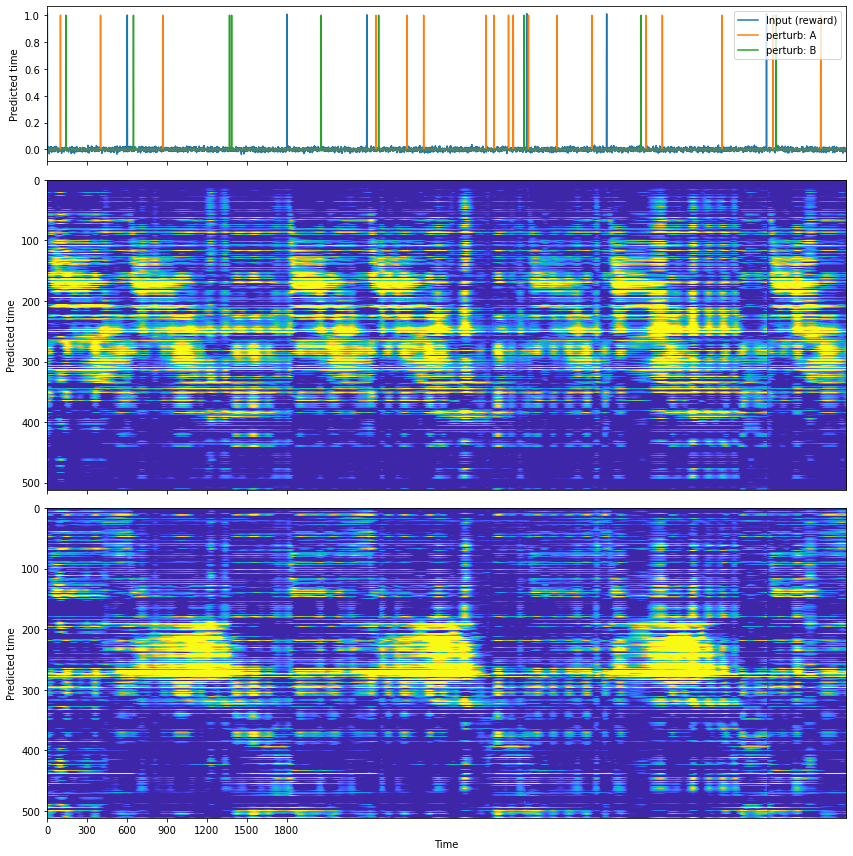

In [22]:
vmax = 12
start=0
end=6000
# make a 3×1 grid, share x, with row heights [1,4,4]
fig, axs = plt.subplots(
    3, 1,
    figsize=(12, 12),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 2, 2]}
)

# ─── Top: line plot ─────────────────────────────
ax0 = axs[0]
ax0.plot(act_x_2[0,start:end],    label='Input (reward)')
ax0.plot(x_2[start:end, 0],         label='perturb: A')
ax0.plot(x_2[start:end, 1],         label='perturb: B')
ax0.set_ylabel("Predicted time")
ax0.legend(loc='upper right')
ax0.grid(False)

# ─── Middle: heatmap A ──────────────────────────
im1 = axs[1].imshow(
    act_A_2[start:end, sort_id_A].T,
    aspect='auto',
    origin='upper',
    cmap=parula,
    interpolation='nearest',
    vmin=0,
    vmax=vmax
)
axs[1].set_ylabel("Predicted time")
#fig.colorbar(im1, ax=axs[1], orientation='vertical', label='Activation')

# ─── Bottom: heatmap B ──────────────────────────
im2 = axs[2].imshow(
    act_B_2[start:end, sort_id_B].T,
    aspect='auto',
    origin='upper',
    cmap=parula,
    interpolation='nearest',
    vmin=0,
    vmax=vmax
)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Predicted time")
#fig.colorbar(im2, ax=axs[2], orientation='vertical', label='Activation')
ticks = [0, 300, 600, 900, 1200, 1500, 1800]

# 2) set them on the x-axis
axs[2].set_xticks(ticks)
plt.tight_layout()
plt.show()